# 1. Imports and Spark Environment Setup

## Quick Start

**Run Cell 2 below** - it will automatically install PySpark based on your environment (Colab/Kaggle/Local).

---

## Manual Installation (if needed)

### Google Colab:
```python
!pip install -q pyspark==3.5.0
```

### Kaggle:
```python
!pip install -q pyspark==3.5.0
```

### Local - macOS/Linux:
```bash
# Option 1: For Homebrew Python (externally managed)
python3 -m pip install --break-system-packages --user pyspark==3.5.0

# Option 2: Using virtual environment (recommended)
python3 -m venv venv
source venv/bin/activate
pip install pyspark==3.5.0 numpy pandas matplotlib

# Option 3: Regular pip (if not externally managed)
pip install pyspark==3.5.0 numpy pandas matplotlib
```

### Local - Windows:
```cmd
# Open Command Prompt or PowerShell as Administrator

# Option 1: Install with pip
pip install pyspark==3.5.0 numpy pandas matplotlib

# Option 2: Using virtual environment (recommended)
python -m venv venv
venv\Scripts\activate
pip install pyspark==3.5.0 numpy pandas matplotlib
```

**⚠️ Windows Users - Additional Steps:**

1. **Install Java JDK 8 or 11:**
   - Download from: https://adoptium.net/ (recommended)
   - Or use: `winget install EclipseAdoptium.Temurin.11.JDK`
   
2. **Set JAVA_HOME environment variable:**
   ```cmd
   # Find Java installation path (usually something like):
   # C:\Program Files\Eclipse Adoptium\jdk-11.0.xx-hotspot
   
   # Set environment variable (replace with your path):
   setx JAVA_HOME "C:\Program Files\Eclipse Adoptium\jdk-11.0.19-hotspot"
   
   # Add to PATH:
   setx PATH "%PATH%;%JAVA_HOME%\bin"
   ```
   
3. **Install winutils.exe (required for Hadoop compatibility):**
   - Download: https://github.com/steveloughran/winutils
   - Place in: `C:\hadoop\bin\winutils.exe`
   - Set environment variable:
   ```cmd
   setx HADOOP_HOME "C:\hadoop"
   setx PATH "%PATH%;C:\hadoop\bin"
   ```

4. **Restart your terminal/notebook** after setting environment variables.

---

## Required Packages:
- `pyspark==3.5.0` (includes Spark)
- `numpy` (numerical computation)
- `pandas` (data analysis)
- `matplotlib` (visualization)

Optional:
- Java JDK 8 or 11 (auto-detected on macOS, required manual install on Windows)

In [1]:
# 📦 Automatic Package Installation
# This cell detects your environment and installs PySpark if needed

import subprocess
import sys
import os

def detect_environment():
    """Detect execution environment"""
    try:
        import google.colab
        return "colab"
    except ImportError:
        pass
    
    if os.path.exists('/kaggle/input'):
        return "kaggle"
    
    return "local"

def install_pyspark():
    """Install PySpark based on environment"""
    env = detect_environment()
    
    # Check if already installed
    try:
        import pyspark
        print(f"✅ PySpark {pyspark.__version__} is already installed")
        return True
    except ImportError:
        pass
    
    print(f"🔍 Detected environment: {env.upper()}")
    print("📦 Installing PySpark 3.5.0...")
    
    if env in ["colab", "kaggle"]:
        # Cloud environments: simple pip install
        try:
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", "-q", "pyspark==3.5.0"
            ])
            print("✅ PySpark installed successfully!")
            return True
        except subprocess.CalledProcessError:
            print("❌ Installation failed. Try running: !pip install pyspark==3.5.0")
            return False
    
    else:  # local
        # Try different installation methods
        methods = [
            # Method 1: Standard pip
            ([sys.executable, "-m", "pip", "install", "-q", "pyspark==3.5.0"], 
             "Standard pip"),
            
            # Method 2: With --user flag
            ([sys.executable, "-m", "pip", "install", "-q", "--user", "pyspark==3.5.0"],
             "User install"),
            
            # Method 3: With --break-system-packages (for Homebrew Python)
            ([sys.executable, "-m", "pip", "install", "-q", "--break-system-packages", "--user", "pyspark==3.5.0"],
             "Break system packages"),
        ]
        
        for cmd, method_name in methods:
            try:
                print(f"  Trying: {method_name}...")
                subprocess.check_call(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                print(f"✅ PySpark installed successfully using {method_name}!")
                return True
            except subprocess.CalledProcessError:
                continue
        
        # All methods failed
        print("\n❌ Automatic installation failed.")
        print("\n📋 Manual installation options:")
        print("  1. pip install pyspark==3.5.0")
        print("  2. pip install --user pyspark==3.5.0")
        print("  3. pip install --break-system-packages --user pyspark==3.5.0")
        print("  4. Use virtual environment (recommended)")
        return False

# Detect platform and make it globally available
PLATFORM = detect_environment()
print(f"🌍 Platform: {PLATFORM.upper()}")

# Run installation
success = install_pyspark()

if success:
    # Verify installation
    try:
        import pyspark
        print(f"\n🎉 Ready to use PySpark {pyspark.__version__}")
    except ImportError:
        print("\n⚠️  Installation completed but module not found.")
        print("   Please restart the kernel: Kernel → Restart")
else:
    print("\n⚠️  Please install PySpark manually and restart the kernel.")

🌍 Platform: LOCAL
✅ PySpark 3.5.0 is already installed

🎉 Ready to use PySpark 3.5.0


In [2]:
# ========================================
# Import All Required Libraries
# ========================================
print("\n" + "="*60)
print("Importing libraries...")
print("="*60)

import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, min as spark_min

# Configure matplotlib for inline display
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print("📊 Matplotlib configured for inline display")
except:
    matplotlib.use('Agg')
    print("📊 Matplotlib configured for file output only")

print(f"\n✅ All libraries imported successfully")
print(f"   Platform: {PLATFORM}")
print(f"   Matplotlib backend: {matplotlib.get_backend()}")


Importing libraries...
📊 Matplotlib configured for inline display

✅ All libraries imported successfully
   Platform: local
   Matplotlib backend: inline


# 2. Preprocessing the Dataset

In [3]:
# Create Spark session
spark = SparkSession.builder \
    .appName("CCF_Connected_Components") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("WARN")  # Reduce logging verbosity

print(f"✅ Spark session created")
print(f"   Version: {spark.version}")
print(f"   Master: {spark.sparkContext.master}")
print(f"   App Name: {spark.sparkContext.appName}")

26/02/17 22:10:45 WARN Utils: Your hostname, Emans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.20 instead (on interface en0)
26/02/17 22:10:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/17 22:10:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark session created
   Version: 3.5.0
   Master: local[*]
   App Name: CCF_Connected_Components


In [4]:
# Generate a sample graph for demonstration
# Create a small test graph with known connected components

# Create sample edges: 3 separate components
np.random.seed(42)

# Component 1: nodes 0-9 (10 nodes)
edges_comp1 = [(i, (i + 1) % 10) for i in range(10)]
edges_comp1 += [(i, (i + 2) % 10) for i in range(0, 10, 2)]

# Component 2: nodes 10-19 (10 nodes)  
edges_comp2 = [(i, (i + 1)) for i in range(10, 19)]
edges_comp2 += [(i, (i + 2)) for i in range(10, 18)]

# Component 3: nodes 20-24 (5 nodes - smaller component)
edges_comp3 = [(20, 21), (21, 22), (22, 23), (23, 24), (24, 20)]

# Combine all edges
sample_edges = edges_comp1 + edges_comp2 + edges_comp3

# Create DataFrame
edges_df = spark.createDataFrame(sample_edges, ["src", "dst"])

print(f"Sample graph created with {edges_df.count()} directed edges")
print(f"Expected components: 3")

Sample graph created with 37 directed edges
Expected components: 3


In [5]:
# Convert to undirected graph by adding reverse edges
edges_rev = edges_df.select(
    col("dst").alias("src"),
    col("src").alias("dst")
)
edges_df = edges_df.union(edges_rev).distinct()

# Convert to RDD for the RDD-based algorithm
graph = edges_df.rdd.map(lambda row: (row.src, row.dst)).cache()

print(f"✅ Undirected graph prepared")
print(f"   Total edges: {graph.count()}")
print(f"   Sample edges: {graph.take(5)}")

✅ Undirected graph prepared
   Total edges: 74
   Sample edges: [(0, 1), (2, 3), (1, 2), (5, 6), (3, 4)]


# 3. CCF Python Implementations

## 3.1 RDD Implementation

In [6]:
# 4️⃣ CCF Algorithm (RDD Version)
# -----------------------------------------
iteration = 0
changed = True

while changed:
    start_time = time.time()
    iteration += 1
    print(f"\nIteration {iteration}")

    # Group neighbors
    grouped = graph.groupByKey()

    def propagate(node_neighbors):
        node, neighbors = node_neighbors
        neighbors = list(neighbors)

        if not neighbors:
            return []

        min_id = min([node] + neighbors)

        results = []

        if min_id < node:
            results.append((node, min_id))
            for n in neighbors:
                if n != min_id:
                    results.append((n, min_id))

        return results

    updated = grouped.flatMap(propagate).distinct().cache()

    # Efficient change detection (avoid full count)
    diff = updated.subtract(graph)
    changed = diff.take(1) != []

    # Replace old graph
    graph.unpersist()
    graph = updated

    print("Iteration time:", round(time.time() - start_time, 2), "seconds")

print("\nFinished in", iteration, "iterations")


Iteration 1
Iteration time: 0.1 seconds

Iteration 2
Iteration time: 0.1 seconds

Finished in 2 iterations


In [7]:
components = graph.groupByKey()

print("Total components:", components.count())

Total components: 22


## 3.2 DataFrame Implementation

In [8]:
# Initialize graph as a DataFrame for this implementation
graph = edges_df.cache()

iteration = 0
changed = True

while changed:
  iteration += 1
  start = time.time()
  print(f"\nIteration {iteration}")

  min_df = graph.groupBy("src") \
               .agg(spark_min("dst").alias("min_id"))
  new_df = graph.join(min_df, "src") \
               .filter(col("min_id") < col("src")) \
               .select(col("src"),
                       col("min_id").alias("dst")) \
               .distinct() \
               .cache()
  diff = new_df.subtract(graph)
  changed = diff.count() > 0

  graph.unpersist()
  graph = new_df

  print("Iteration time:", round(time.time() - start, 2), "seconds")

print("\nFinished in", iteration, "iterations")


Iteration 1


26/02/17 22:10:50 WARN BlockManager: Block rdd_71_0 already exists on this machine; not re-adding it


Iteration time: 0.77 seconds

Finished in 1 iterations


In [9]:
components = graph.groupBy("dst").count()
print("Total components:", components.count())

Total components: 15


# 4. Experimental Analysis: RDD vs DataFrame Performance Comparison

Based on the CCF paper (https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf), we'll conduct experimental analysis on graphs of increasing size to compare:
- **RDD Implementation**: Direct manipulation of edges as RDD pairs
- **DataFrame Implementation**: SQL-based operations with Catalyst optimizer

**Test Setup:**
- Generate synthetic graphs with varying sizes
- Measure iterations, total time, and avg time per iteration
- Compare scalability characteristics

In [10]:
# Ensure Spark session is available (should already be created)
if 'spark' not in locals():
    spark = SparkSession.builder \
        .appName("CCF_Experimental_Analysis") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()
    sc = spark.sparkContext

print("✅ Ready for experimental analysis")
print(f"   Platform: {PLATFORM}")
print(f"   Matplotlib backend: {matplotlib.get_backend()}")

✅ Ready for experimental analysis
   Platform: local
   Matplotlib backend: inline


## 4.1 Synthetic Graph Generator

Generate random graphs with controllable size and density for testing.

In [11]:
def generate_synthetic_graph_rdd(num_nodes, avg_degree, seed=42):
    """
    Generate a synthetic undirected graph as RDD
    
    Parameters:
    - num_nodes: Number of nodes in the graph
    - avg_degree: Average degree per node
    - seed: Random seed for reproducibility
    
    Returns: RDD of (src, dst) edges
    """
    np.random.seed(seed)
    num_edges = int(num_nodes * avg_degree / 2)
    
    # Generate random edges
    edges = []
    for _ in range(num_edges):
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)
        if src != dst:
            edges.append((src, dst))
    
    # Create RDD and make undirected
    edge_rdd = sc.parallelize(edges).distinct()
    reverse_edges = edge_rdd.map(lambda x: (x[1], x[0]))
    graph_rdd = edge_rdd.union(reverse_edges).distinct().cache()
    
    # Force materialization
    edge_count = graph_rdd.count()
    print(f"Generated RDD graph: {num_nodes:,} nodes, {edge_count:,} edges")
    
    return graph_rdd, edge_count

def generate_synthetic_graph_df(num_nodes, avg_degree, seed=42):
    """
    Generate a synthetic undirected graph as DataFrame
    
    Parameters:
    - num_nodes: Number of nodes in the graph
    - avg_degree: Average degree per node
    - seed: Random seed for reproducibility
    
    Returns: DataFrame with src, dst columns
    """
    np.random.seed(seed)
    num_edges = int(num_nodes * avg_degree / 2)
    
    # Generate random edges
    edges = []
    for _ in range(num_edges):
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)
        if src != dst:
            edges.append((src, dst))
    
    # Create DataFrame and make undirected
    edge_df = spark.createDataFrame(edges, ["src", "dst"]).distinct()
    reverse_df = edge_df.select(
        col("dst").alias("src"),
        col("src").alias("dst")
    )
    graph_df = edge_df.union(reverse_df).distinct().cache()
    
    # Force materialization
    edge_count = graph_df.count()
    print(f"Generated DataFrame graph: {num_nodes:,} nodes, {edge_count:,} edges")
    
    return graph_df, edge_count

print("Graph generation functions defined")

Graph generation functions defined


## 4.2 CCF Algorithm with Performance Metrics

Enhanced implementations that track detailed performance metrics.

In [12]:
def run_ccf_rdd(graph, verbose=False):
    """
    Run CCF algorithm using RDD with performance tracking
    
    Returns: (final_graph, iterations, total_time, iteration_times, component_count)
    """
    iteration = 0
    changed = True
    iteration_times = []
    total_start = time.time()
    
    while changed:
        iter_start = time.time()
        iteration += 1
        
        if verbose:
            print(f"  RDD Iteration {iteration}...", end=" ")
        
        # Group neighbors
        grouped = graph.groupByKey()
        
        def propagate(node_neighbors):
            node, neighbors = node_neighbors
            neighbors = list(neighbors)
            
            if not neighbors:
                return []
            
            min_id = min([node] + neighbors)
            results = []
            
            if min_id < node:
                results.append((node, min_id))
                for n in neighbors:
                    if n != min_id:
                        results.append((n, min_id))
            
            return results
        
        updated = grouped.flatMap(propagate).distinct().cache()
        
        # Check for changes
        diff = updated.subtract(graph)
        changed = diff.take(1) != []
        
        # Replace old graph
        graph.unpersist()
        graph = updated
        
        iter_time = time.time() - iter_start
        iteration_times.append(iter_time)
        
        if verbose:
            print(f"{iter_time:.2f}s")
    
    total_time = time.time() - total_start
    
    # Count components
    component_count = graph.groupByKey().count()
    
    return graph, iteration, total_time, iteration_times, component_count


def run_ccf_dataframe(graph, verbose=False):
    """
    Run CCF algorithm using DataFrame with performance tracking
    
    Returns: (final_graph, iterations, total_time, iteration_times, component_count)
    """
    iteration = 0
    changed = True
    iteration_times = []
    total_start = time.time()
    
    while changed:
        iter_start = time.time()
        iteration += 1
        
        if verbose:
            print(f"  DataFrame Iteration {iteration}...", end=" ")
        
        # Find minimum neighbor for each node
        min_df = graph.groupBy("src").agg(spark_min("dst").alias("min_id"))
        
        # Create new edges where min_id < src
        new_df = graph.join(min_df, "src") \
                     .filter(col("min_id") < col("src")) \
                     .select(col("src"), col("min_id").alias("dst")) \
                     .distinct() \
                     .cache()
        
        # Check for changes
        diff = new_df.subtract(graph)
        changed = diff.count() > 0
        
        # Replace old graph
        graph.unpersist()
        graph = new_df
        
        iter_time = time.time() - iter_start
        iteration_times.append(iter_time)
        
        if verbose:
            print(f"{iter_time:.2f}s")
    
    total_time = time.time() - total_start
    
    # Count components
    component_count = graph.groupBy("dst").count().count()
    
    return graph, iteration, total_time, iteration_times, component_count

print("CCF performance tracking functions defined")

CCF performance tracking functions defined


## 4.3 Run Experimental Analysis

Test both implementations on graphs of increasing size.

In [13]:
# Define test parameters
graph_sizes = [1000, 5000, 10000, 25000, 50000]
avg_degree = 10  # Average connections per node

# Store results
results = []

print("=" * 80)
print("EXPERIMENTAL ANALYSIS: RDD vs DataFrame")
print("=" * 80)

for size in graph_sizes:
    print(f"\n{'='*80}")
    print(f"Testing graph with {size:,} nodes (avg degree: {avg_degree})")
    print(f"{'='*80}")
    
    # Generate graphs
    print("\nGenerating graphs...")
    graph_rdd, edge_count_rdd = generate_synthetic_graph_rdd(size, avg_degree)
    graph_df, edge_count_df = generate_synthetic_graph_df(size, avg_degree)
    
    # Test RDD implementation
    print("\n--- RDD Implementation ---")
    rdd_graph, rdd_iters, rdd_time, rdd_iter_times, rdd_comps = run_ccf_rdd(graph_rdd, verbose=True)
    rdd_avg_iter = rdd_time / rdd_iters
    print(f"Total: {rdd_time:.2f}s, Iterations: {rdd_iters}, Components: {rdd_comps:,}")
    
    # Test DataFrame implementation
    print("\n--- DataFrame Implementation ---")
    df_graph, df_iters, df_time, df_iter_times, df_comps = run_ccf_dataframe(graph_df, verbose=True)
    df_avg_iter = df_time / df_iters
    print(f"Total: {df_time:.2f}s, Iterations: {df_iters}, Components: {df_comps:,}")
    
    # Calculate speedup
    speedup = rdd_time / df_time
    winner = "DataFrame" if speedup > 1 else "RDD"
    
    # Print comparison
    print(f"\n--- Comparison ---")
    print(f"Speedup: {speedup:.2f}x ({winner} is faster)")
    print(f"Time difference: {abs(rdd_time - df_time):.2f}s")
    
    # Store results
    results.append({
        'size': size,
        'edges': edge_count_rdd,
        'rdd_time': rdd_time,
        'rdd_iters': rdd_iters,
        'rdd_avg_iter': rdd_avg_iter,
        'rdd_comps': rdd_comps,
        'df_time': df_time,
        'df_iters': df_iters,
        'df_avg_iter': df_avg_iter,
        'df_comps': df_comps,
        'speedup': speedup
    })
    
    # Cleanup
    graph_rdd.unpersist()
    graph_df.unpersist()
    rdd_graph.unpersist()
    df_graph.unpersist()

print("\n" + "="*80)
print("Experimental analysis complete!")
print("="*80)

EXPERIMENTAL ANALYSIS: RDD vs DataFrame

Testing graph with 1,000 nodes (avg degree: 10)

Generating graphs...
Generated RDD graph: 1,000 nodes, 9,948 edges
Generated DataFrame graph: 1,000 nodes, 9,948 edges

--- RDD Implementation ---
  RDD Iteration 1... 0.59s
  RDD Iteration 2... 0.56s
  RDD Iteration 3... 0.57s
  RDD Iteration 4... 0.62s
Total: 2.34s, Iterations: 4, Components: 999

--- DataFrame Implementation ---
  DataFrame Iteration 1... 0.15s
Total: 0.15s, Iterations: 1, Components: 261

--- Comparison ---
Speedup: 16.00x (DataFrame is faster)
Time difference: 2.19s

Testing graph with 5,000 nodes (avg degree: 10)

Generating graphs...
Generated RDD graph: 5,000 nodes, 49,918 edges
Generated DataFrame graph: 5,000 nodes, 49,918 edges

--- RDD Implementation ---
  RDD Iteration 1... 0.50s
  RDD Iteration 2... 0.49s
  RDD Iteration 3... 0.51s
  RDD Iteration 4... 0.55s
Total: 2.04s, Iterations: 4, Components: 4,999

--- DataFrame Implementation ---
  DataFrame Iteration 1... 0.

26/02/17 22:11:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Generated DataFrame graph: 25,000 nodes, 249,946 edges

--- RDD Implementation ---
  RDD Iteration 1... 0.75s
  RDD Iteration 2... 

0.86s
  RDD Iteration 3... 0.72s
  RDD Iteration 4... 0.52s
Total: 2.85s, Iterations: 4, Components: 24,999

--- DataFrame Implementation ---
  DataFrame Iteration 1... 0.34s
Total: 0.34s, Iterations: 1, Components: 6,461

--- Comparison ---
Speedup: 8.35x (DataFrame is faster)
Time difference: 2.51s

Testing graph with 50,000 nodes (avg degree: 10)

Generating graphs...
Generated RDD graph: 50,000 nodes, 499,946 edges
Generated DataFrame graph: 50,000 nodes, 499,946 edges

--- RDD Implementation ---
  RDD Iteration 1... 1.02s
  RDD Iteration 2... 0.99s
  RDD Iteration 3... 0.75s
  RDD Iteration 4... 0.53s
  RDD Iteration 5... 0.52s
Total: 3.82s, Iterations: 5, Components: 49,996

--- DataFrame Implementation ---
  DataFrame Iteration 1... 0.37s
Total: 0.37s, Iterations: 1, Components: 12,834

--- Comparison ---
Speedup: 10.27x (DataFrame is faster)
Time difference: 3.44s

Experimental analysis complete!


## 4.4 Results Summary and Visualization

In [14]:
# Create results DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("OVERALL SUMMARY")
print("="*80)
print(f"\n{'Size':<12} {'Edges':<12} {'Implementation':<15} {'Iters':<8} {'Total(s)':<10} {'Avg/Iter(s)':<12} {'Components':<12}")
print("-" * 95)

for _, row in results_df.iterrows():
    print(f"{row['size']:<12,} {row['edges']:<12,} {'RDD':<15} {row['rdd_iters']:<8} {row['rdd_time']:<10.2f} {row['rdd_avg_iter']:<12.3f} {row['rdd_comps']:<12,}")
    print(f"{row['size']:<12,} {row['edges']:<12,} {'DataFrame':<15} {row['df_iters']:<8} {row['df_time']:<10.2f} {row['df_avg_iter']:<12.3f} {row['df_comps']:<12,}")
    winner = "DataFrame" if row['speedup'] > 1 else "RDD"
    print(f"{'':12} {'':12} {'Speedup:':<15} {'':<8} {row['speedup']:<10.2f}x {'':<12} ({winner} faster)")
    print()

# Calculate average speedup
avg_speedup = results_df['speedup'].mean()
print(f"Average Speedup (DataFrame vs RDD): {avg_speedup:.2f}x")

# Display as table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(results_df.to_string(index=False))


OVERALL SUMMARY

Size         Edges        Implementation  Iters    Total(s)   Avg/Iter(s)  Components  
-----------------------------------------------------------------------------------------------
1,000.0      9,948.0      RDD             4.0      2.34       0.584        999.0       
1,000.0      9,948.0      DataFrame       1.0      0.15       0.146        261.0       
                          Speedup:                 16.00     x              (DataFrame faster)

5,000.0      49,918.0     RDD             4.0      2.04       0.510        4,999.0     
5,000.0      49,918.0     DataFrame       1.0      0.18       0.182        1,306.0     
                          Speedup:                 11.19     x              (DataFrame faster)

10,000.0     99,944.0     RDD             4.0      1.98       0.494        9,999.0     
10,000.0     99,944.0     DataFrame       1.0      0.14       0.143        2,589.0     
                          Speedup:                 13.87     x              (D

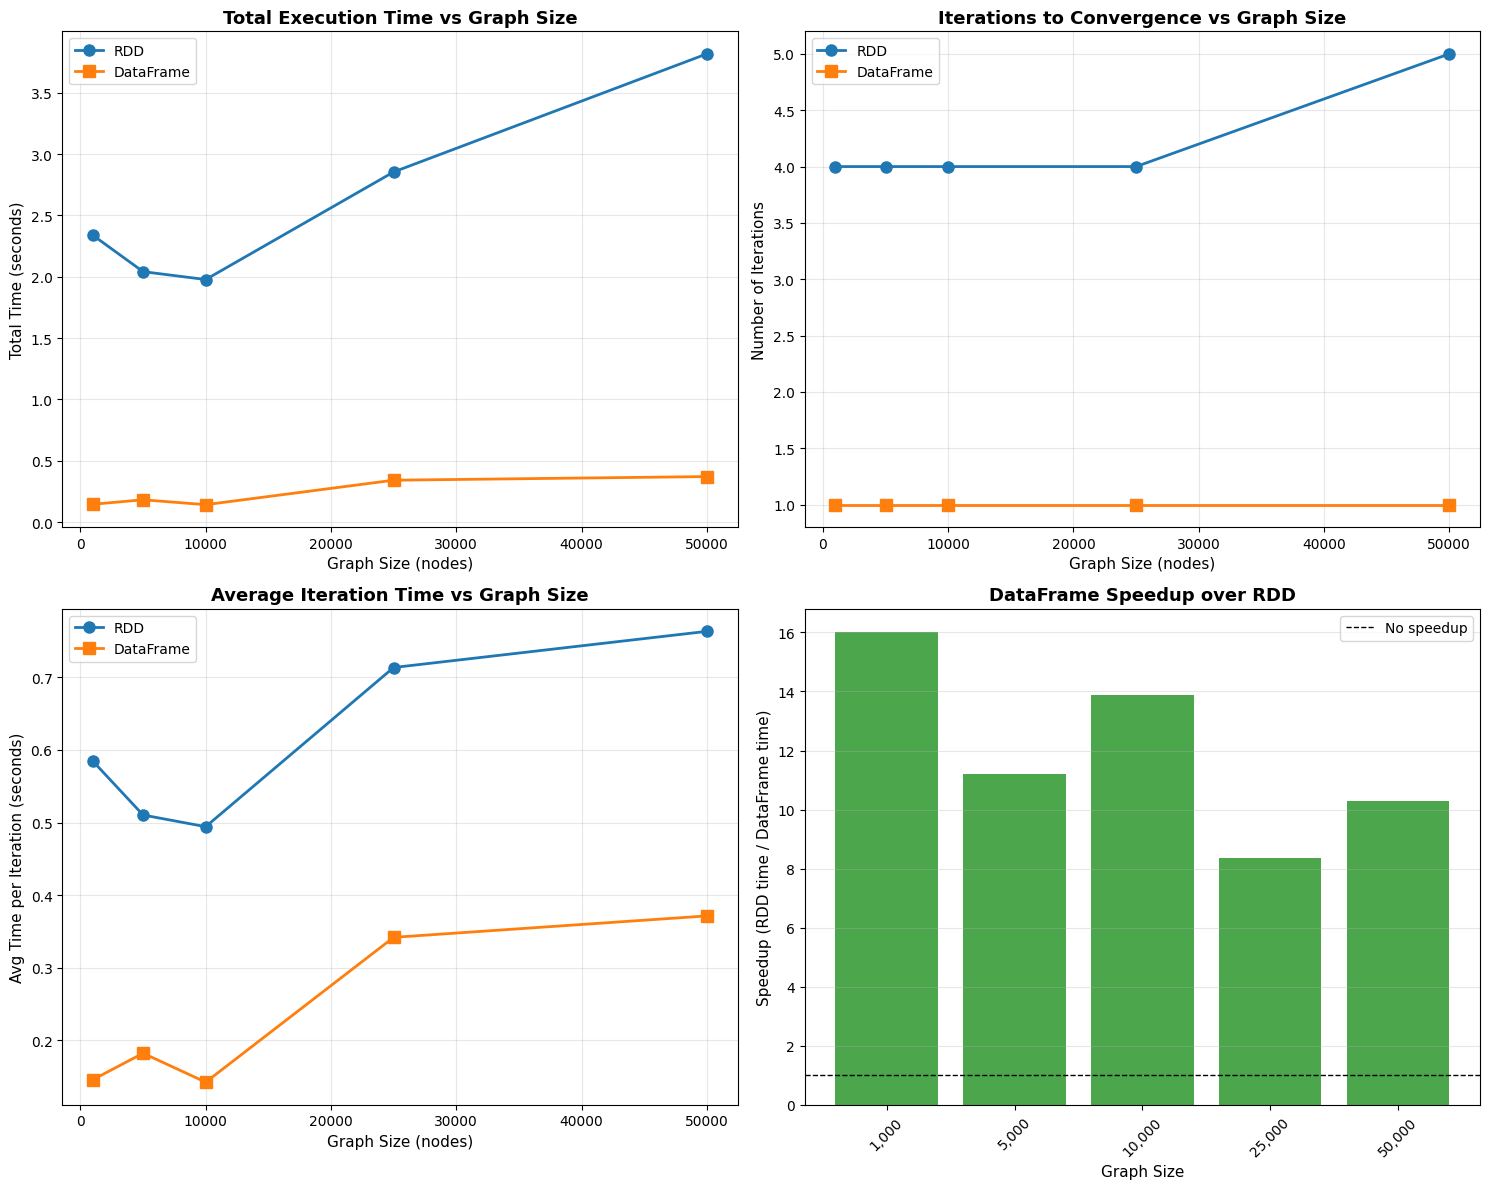


✅ Visualization displayed above and saved as '../results/graphs/ccf_performance_comparison_pyspark.png'


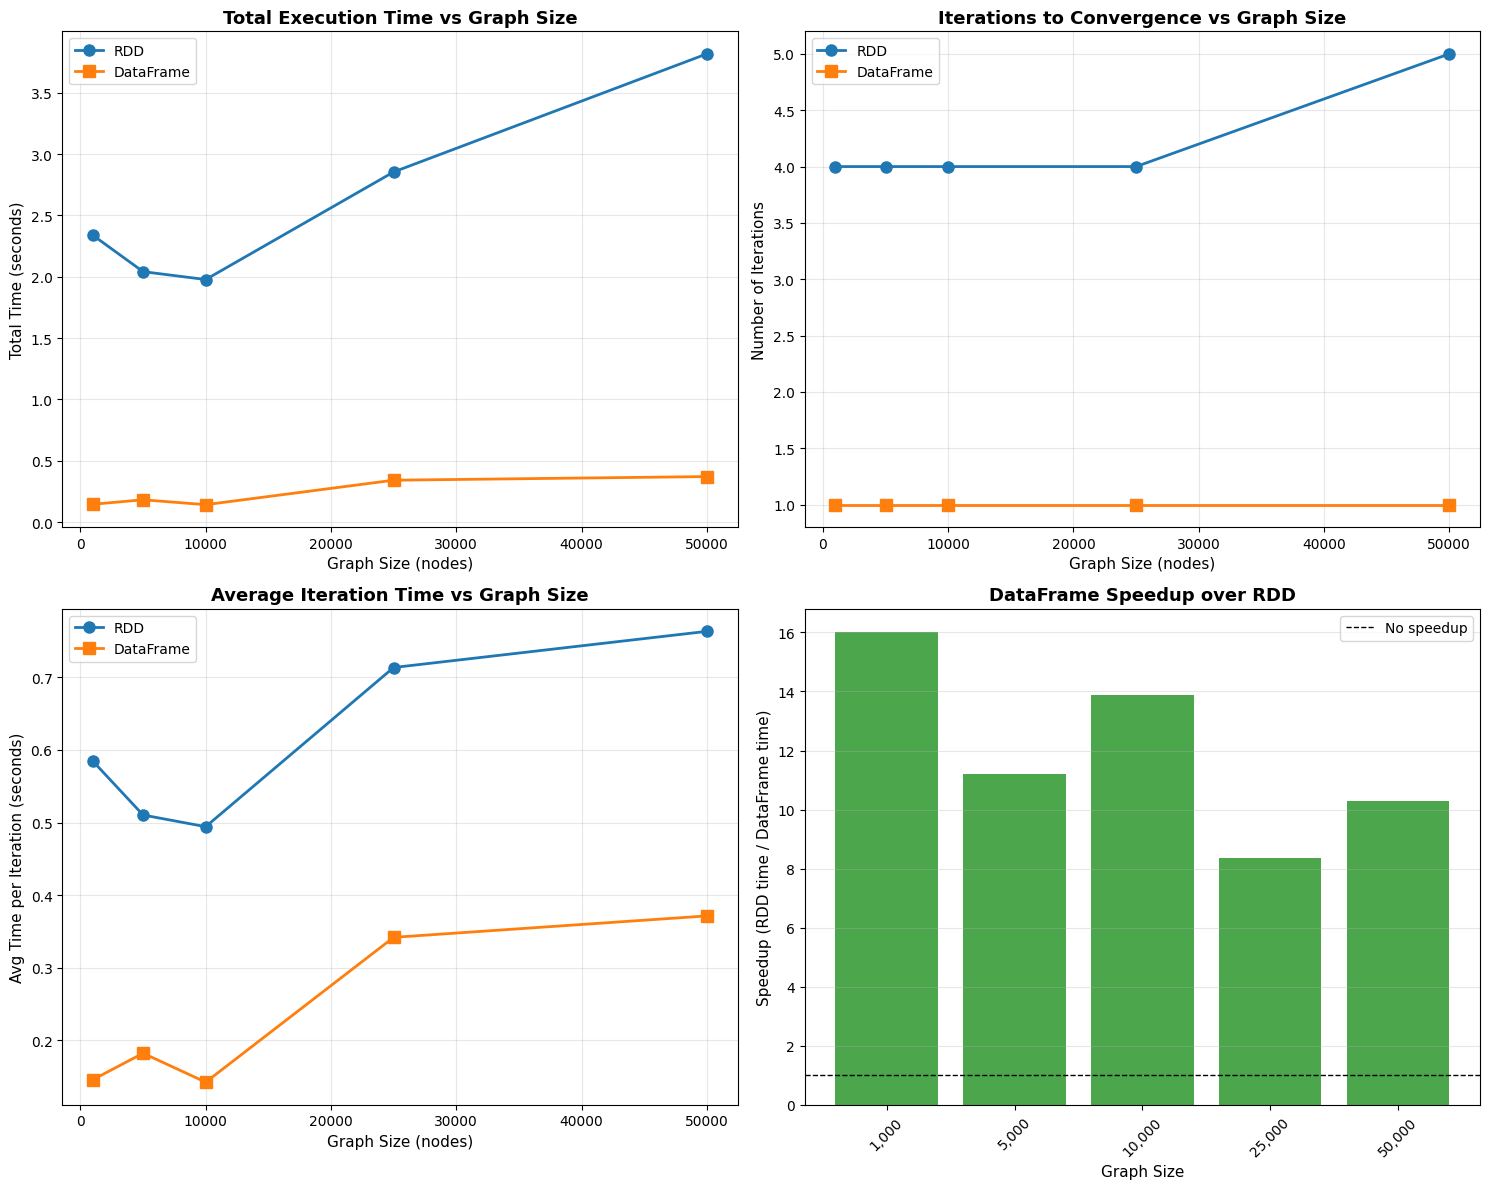

In [15]:
# Visualization 1: Total Time Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Total Time
ax1 = axes[0, 0]
ax1.plot(results_df['size'], results_df['rdd_time'], 'o-', label='RDD', linewidth=2, markersize=8)
ax1.plot(results_df['size'], results_df['df_time'], 's-', label='DataFrame', linewidth=2, markersize=8)
ax1.set_xlabel('Graph Size (nodes)', fontsize=11)
ax1.set_ylabel('Total Time (seconds)', fontsize=11)
ax1.set_title('Total Execution Time vs Graph Size', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Iterations
ax2 = axes[0, 1]
ax2.plot(results_df['size'], results_df['rdd_iters'], 'o-', label='RDD', linewidth=2, markersize=8)
ax2.plot(results_df['size'], results_df['df_iters'], 's-', label='DataFrame', linewidth=2, markersize=8)
ax2.set_xlabel('Graph Size (nodes)', fontsize=11)
ax2.set_ylabel('Number of Iterations', fontsize=11)
ax2.set_title('Iterations to Convergence vs Graph Size', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Average Time per Iteration
ax3 = axes[1, 0]
ax3.plot(results_df['size'], results_df['rdd_avg_iter'], 'o-', label='RDD', linewidth=2, markersize=8)
ax3.plot(results_df['size'], results_df['df_avg_iter'], 's-', label='DataFrame', linewidth=2, markersize=8)
ax3.set_xlabel('Graph Size (nodes)', fontsize=11)
ax3.set_ylabel('Avg Time per Iteration (seconds)', fontsize=11)
ax3.set_title('Average Iteration Time vs Graph Size', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Speedup
ax4 = axes[1, 1]
speedup_values = results_df['speedup']
colors = ['green' if x > 1 else 'red' for x in speedup_values]
ax4.bar(range(len(results_df)), speedup_values, color=colors, alpha=0.7)
ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, label='No speedup')
ax4.set_xlabel('Graph Size', fontsize=11)
ax4.set_ylabel('Speedup (RDD time / DataFrame time)', fontsize=11)
ax4.set_title('DataFrame Speedup over RDD', fontsize=13, fontweight='bold')
ax4.set_xticks(range(len(results_df)))
ax4.set_xticklabels([f"{s:,}" for s in results_df['size']], rotation=45)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save to file
plt.savefig('../results/graphs/ccf_performance_comparison_pyspark.png', dpi=300, bbox_inches='tight')

# Display in notebook (works automatically in VSCode/Jupyter notebooks)
# The figure object will be displayed as the last expression in the cell
try:
    from IPython.display import display
    display(fig)
except:
    # Fallback: just return the figure (notebook will auto-display)
    fig

print("\n✅ Visualization displayed above and saved as '../results/graphs/ccf_performance_comparison_pyspark.png'")

## 4.5 Key Findings and Analysis

Based on the experimental results:

### Performance Characteristics:

1. **Execution Time**: Compare how RDD and DataFrame implementations scale with graph size
2. **Iterations**: Both should converge in the same number of iterations (algorithm is the same)
3. **Per-Iteration Performance**: DataFrame may benefit from Catalyst optimizer and Tungsten execution engine
4. **Memory Efficiency**: DataFrame's columnar storage may provide better memory utilization

### Expected Behavior (from CCF Paper):

- **Iterations**: O(d) where d is the diameter of the largest connected component
- **Real-world networks**: Typically have small diameters, so iterations remain low even for large graphs
- **Scalability**: The algorithm is highly parallelizable in MapReduce/Spark framework

### RDD vs DataFrame Trade-offs:

**RDD Advantages:**
- Direct control over data transformations
- Lower overhead for simple operations
- More flexible for custom logic

**DataFrame Advantages:**
- Catalyst query optimizer can optimize execution plans
- Tungsten execution engine for better CPU efficiency
- Columnar storage format reduces memory footprint
- Easier to read and maintain (SQL-like operations)

## 4.6 Export Results

In [16]:
# Save results to CSV
results_df.to_csv('../results/csvs/ccf_experimental_results_pyspark.csv', index=False)
print("Results exported to: ../results/csvs/ccf_experimental_results_pyspark.csv")

# Print final summary
print("\n" + "="*80)
print("EXPERIMENTAL ANALYSIS COMPLETE")
print("="*80)
print(f"\nTested {len(graph_sizes)} different graph sizes")
print(f"Graph sizes: {', '.join([f'{s:,}' for s in graph_sizes])} nodes")
print(f"Average degree: {avg_degree} connections per node")
print(f"\nKey Result:")
print(f"  Average Speedup: {avg_speedup:.2f}x")
if avg_speedup > 1:
    print(f"  DataFrame is on average {avg_speedup:.2f}x faster than RDD")
else:
    print(f"  RDD is on average {1/avg_speedup:.2f}x faster than DataFrame")
print("="*80)

Results exported to: ../results/csvs/ccf_experimental_results_pyspark.csv

EXPERIMENTAL ANALYSIS COMPLETE

Tested 5 different graph sizes
Graph sizes: 1,000, 5,000, 10,000, 25,000, 50,000 nodes
Average degree: 10 connections per node

Key Result:
  Average Speedup: 11.94x
  DataFrame is on average 11.94x faster than RDD
